<a href="https://colab.research.google.com/github/deadeal07/DSC212---Assignment-Jabin_Justin-IMS24106/blob/main/DSC212_ASSIGNMENT_IMS24106.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Step 1: Setup, Load Graph, and Initial Plot**

First, I need to set up my environment for the assignment. I'll start by:

1)Importing all the necessary libraries: networkx for graph operations, numpy for matrix math, matplotlib for plotting, and pandas/seaborn for the metric analysis later.

2)Loading the built-in "Zachary's Karate Club Graph" into a variable G. I'll also convert the node labels to integers (0-33) to make the matrix operations easier.

3)Computing and storing a "fixed layout" in a variable named pos. This is a critical part of the assignment. I'll calculate the (x, y) position of each node once and save it. This way, all my future plots will use these exact same positions, and only the node colors will change, making the community splits easy to see.

4)Drawing the initial graph with all nodes in a single color. This will be my "Iteration 0" baseline plot.

Libraries imported successfully.
Graph loaded: 34 nodes, 78 edges.
Fixed spring layout computed and stored in 'pos'.


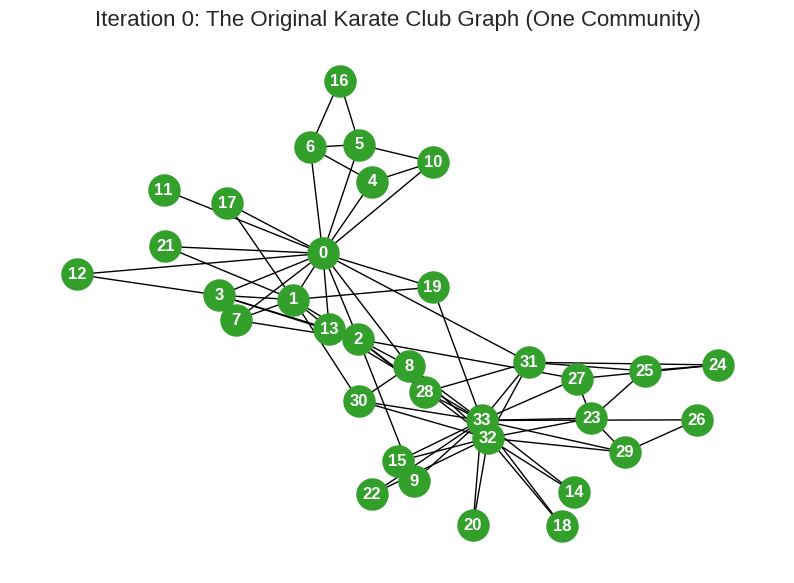

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.sparse.linalg import eigs

# Set a nice plotting style
plt.style.use('seaborn-v0_8-darkgrid')
print("Libraries imported successfully.")

# 1. Load the Karate Club Graph
G = nx.karate_club_graph()
# We'll work with integer labels (0-33) for simplicity
G = nx.convert_node_labels_to_integers(G, first_label=0)
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

# 2. Create and store a fixed layout (CRITICAL for the assignment)
# We compute the layout ONCE and reuse it for all plots.
# A 'seed' ensures the layout is reproducible every time you run the code.
pos = nx.spring_layout(G, seed=42)
print("Fixed spring layout computed and stored in 'pos'.")

# 3. Initial Visualization (Iteration 0)
plt.figure(figsize=(10, 7))
nx.draw_networkx(
    G,
    pos,                 # Use the fixed layout
    node_color='#33a02c', # Start with one color for all nodes
    with_labels=True,
    node_size=500,
    font_color='white',
    font_weight='bold'
)
plt.title("Iteration 0: The Original Karate Club Graph (One Community)", fontsize=16)
plt.axis('off') # Hide the axes
plt.show()

1)get_modularity_matrix(G): This function builds the global modularity matrix $B$ for the entire graph1. It calculates $B = A - \frac{kk^T}{2m}$, where $A$ is the adjacency matrix, $k$ is the degree vector, and $m$ is the total number of edges.

2)find_best_split(B_global, nodes): This function contains the recursive logic.
It takes the global $B$ matrix and a list of nodes

*   It takes the global $B$ matrix and a list of nodes
*   It extracts the restricted modularity matrix $B^{(C)}$ for just those nodes
*  It finds the leading (largest) eigenpair $     (\lambda_1^{(C)}, u_1^{(C)})$ of this restricted matrix.
*  It checks the stopping criterion: If the largest eigenvalue $\lambda_1^{(C)}$ is positive ($\gt 0$), it splits the community; otherwise, if $\lambda_1^{(C)} \le 0$, it stops.





In [6]:
def get_modularity_matrix(G):
    """
    Computes the global modularity matrix B for the entire graph.
    B = A - (k * k^T) / 2m

    """
    # Ensure nodes are 0-indexed integers for easy matrix mapping
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    # Get Adjacency Matrix A
    A = nx.to_numpy_array(G)

    # Get total number of edges m
    m = G.number_of_edges()
    if m == 0:
        return np.zeros(A.shape)

    # Get degree vector k (as a column vector)
    k = A.sum(axis=1).reshape(-1, 1) # k_i = sum_j A_ij [cite: 50]

    # Compute the expected edges matrix (k * k^T) / 2m
    expected_edges = (k @ k.T) / (2 * m) # [cite: 61, 79]

    # B = A - expected
    B = A - expected_edges #
    return B

def find_best_split(B_global, nodes):
    """
    Finds the best spectral split for a given community C (represented by 'nodes').

    Args:
        B_global (np.array): The modularity matrix for the *entire* graph.
        nodes (list): A list of node indices (e.g., [3, 5, 12]) that form
                      the community C we are trying to split.

    Returns:
        (list, list) or None: Two new communities (C1, C2) if a split
                              improves modularity [cite: 128-129], else None.
    """
    if len(nodes) <= 1:
        return None # Can't split a single node

    # Extract the restricted modularity matrix B^(C)
    # np.ix_ is a numpy trick to select a submatrix based on index lists
    B_C = B_global[np.ix_(nodes, nodes)]

    # Find the leading eigenpair (lambda_1, u_1)
    # We ask for k=1 (the largest) eigenvalue, 'LR' = Largest Real part.
    try:
        # We use 'eig' for small dense matrices, 'eigs' for large sparse ones.
        if B_C.shape[0] < 3:
             # eigs can be unstable on 2x2, use eig
            eigvals, eigvecs = np.linalg.eig(B_C)
            max_eig_idx = np.argmax(eigvals)
            lambda_1 = eigvals[max_eig_idx].real
            u_1 = eigvecs[:, max_eig_idx].real
        else:
            # Use eigs for efficiency
            eigvals, eigvecs = eigs(B_C, k=1, which='LR')
            lambda_1 = eigvals[0].real
            u_1 = eigvecs[:, 0].real

    except Exception as e:
        print(f"Eigenvalue computation failed for nodes {nodes}: {e}")
        return None

    # Stopping Criterion: If lambda_1 <= 0, no split improves modularity [cite: 130]
    if lambda_1 <= 1e-10: # Use a small epsilon for float comparison
        return None

    # We have a good split. Divide nodes by the sign of eigenvector u_1 [cite: 128]
    community_1 = []
    community_2 = []
    for i, node_global_index in enumerate(nodes):
        if u_1[i] > 0:
            community_1.append(node_global_index)
        else:
            community_2.append(node_global_index)

    # Handle trivial splits (e.g., all nodes have same sign in u_1)
    if len(community_1) == 0 or len(community_2) == 0:
        return None # This split is not useful

    return community_1, community_2

# --- Run this cell to define the functions ---
print("Algorithm functions defined: get_modularity_matrix() and find_best_split()")

Algorithm functions defined: get_modularity_matrix() and find_best_split()


**Step 3: Run Partitioning, Visualize Splits (Task 2) & Compute Metrics (Task 3)**

Define a helper function, compute_metrics, to calculate all four required node metrics (Degree, Betweenness, Closeness, Clustering). This is for Task 3.

Define another helper function, plot_graph_step, to visualize the graph. This function will use my fixed pos layout from Step 1 and apply different colors to the nodes based on their current community. This is for Task 2.

Use my get_modularity_matrix and find_best_split functions from Step 2 to recursively partition the graph.

I'll create a loop that continues as long as there are communities to split. After each successful split, this loop will:

Visualize the new community structure by calling plot_graph_step (Task 2).

Compute all the node metrics on the full graph by calling compute_metrics (Task 3).

Finally, I'll store all the metrics from each iteration in a history list. I'll need this list in the next step to plot the metric evolution..

--- Iteration 0 (Initial State) ---
Communities: 1 (everyone in group 0)

--- Iteration 1 (Split) ---
Splitting Community 0 -> 1 (size 16) & 2 (size 18)


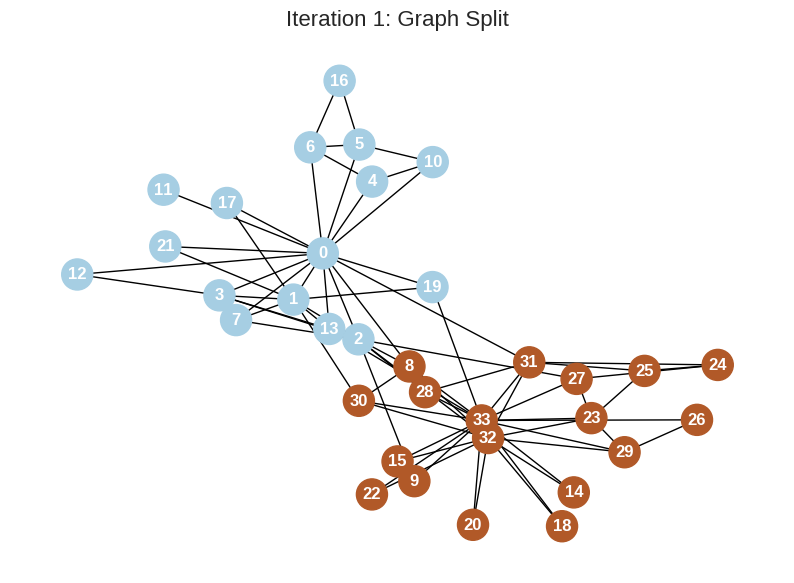


--- Iteration 2 (Split) ---
Splitting Community 1 -> 3 (size 8) & 4 (size 8)


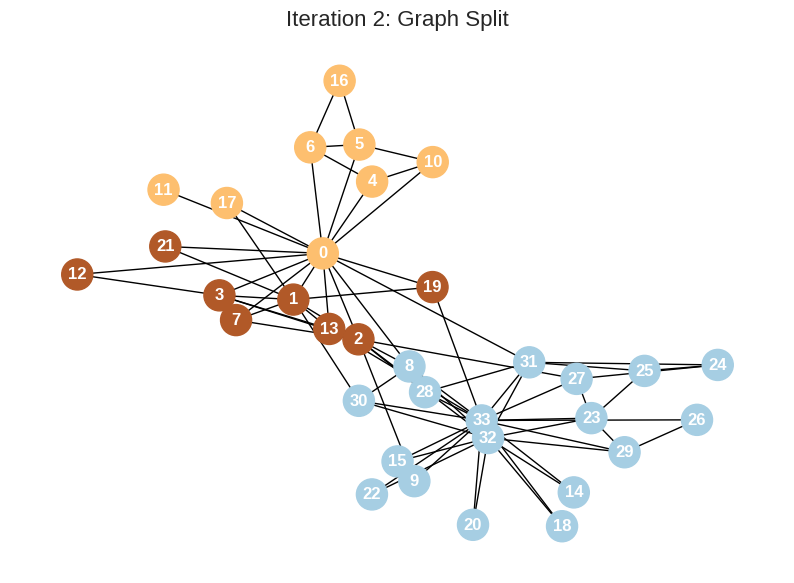


--- Iteration 3 (Split) ---
Splitting Community 2 -> 5 (size 12) & 6 (size 6)


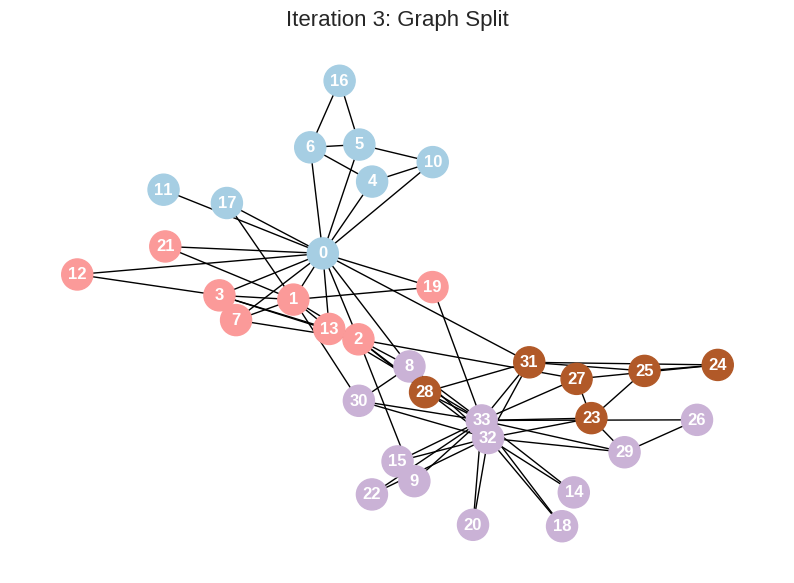


--- Iteration 4 (Split) ---
Splitting Community 3 -> 7 (size 5) & 8 (size 3)


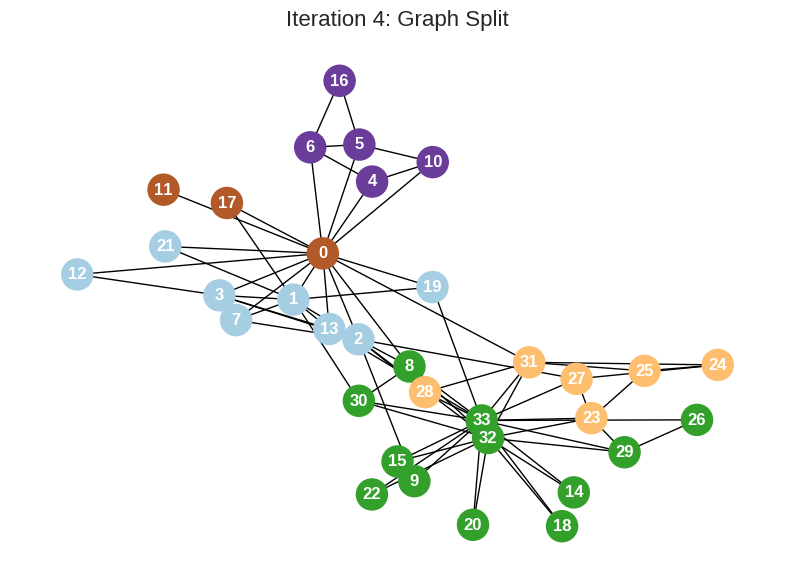


--- Iteration 5 (Split) ---
Splitting Community 4 -> 9 (size 4) & 10 (size 4)


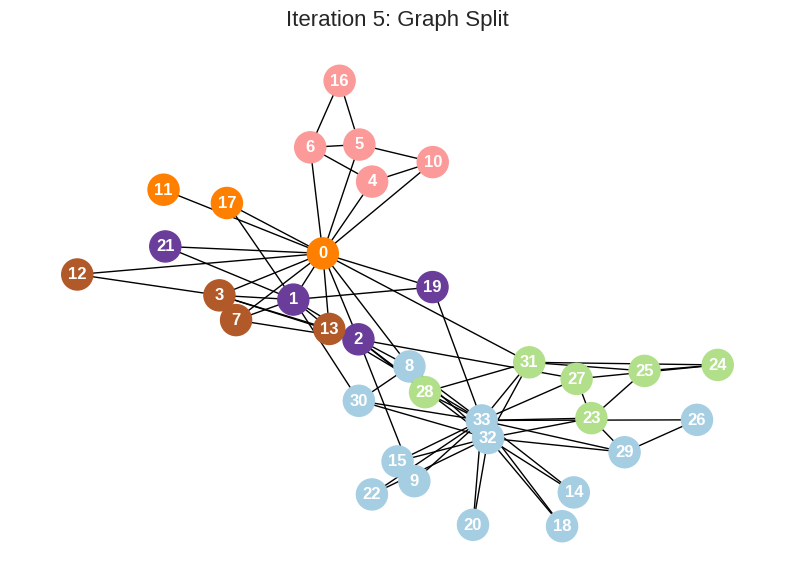


--- Iteration 6 (Split) ---
Splitting Community 5 -> 11 (size 10) & 12 (size 2)


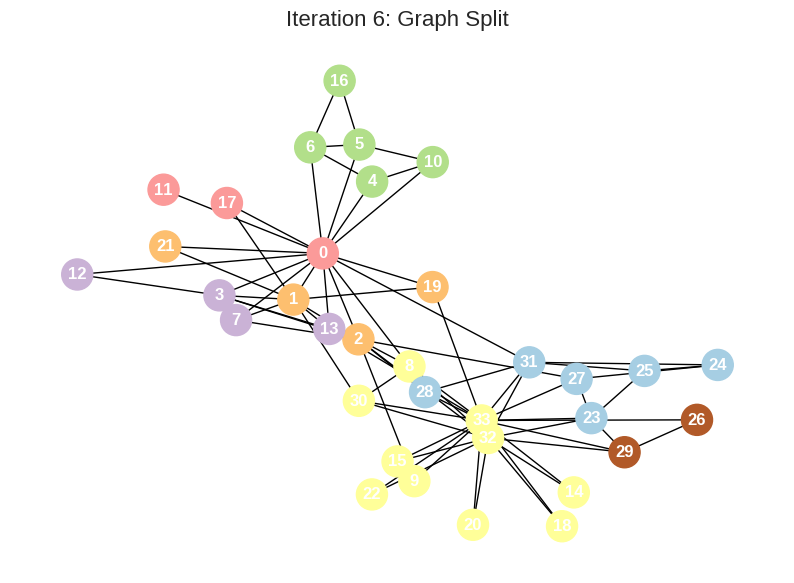


--- Iteration 7 (Split) ---
Splitting Community 6 -> 13 (size 4) & 14 (size 2)


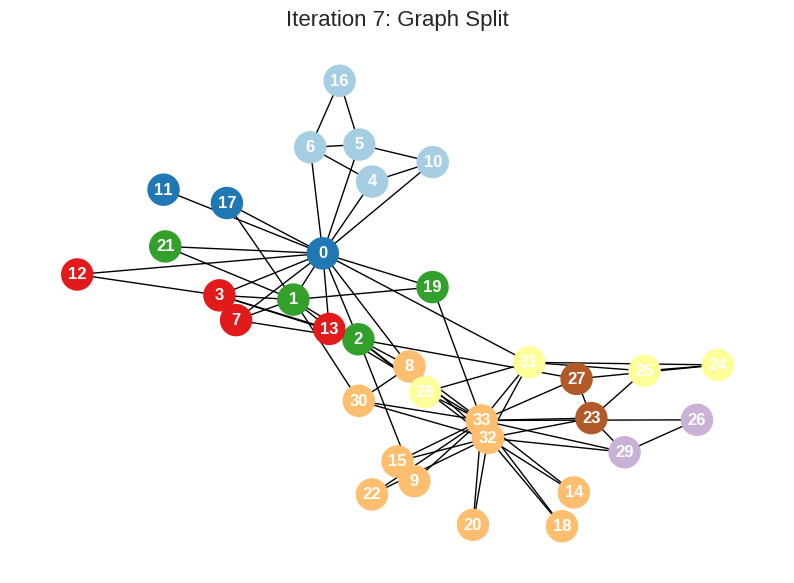


--- Stopping recursion on community 7 (size 5). No modularity gain. ---

--- Stopping recursion on community 8 (size 3). No modularity gain. ---

--- Iteration 8 (Split) ---
Splitting Community 9 -> 15 (size 3) & 16 (size 1)


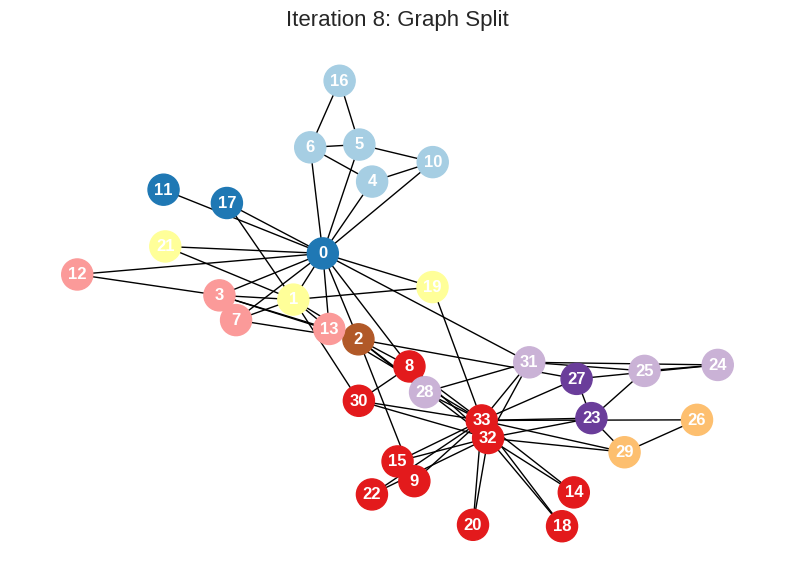


--- Iteration 9 (Split) ---
Splitting Community 10 -> 17 (size 1) & 18 (size 3)


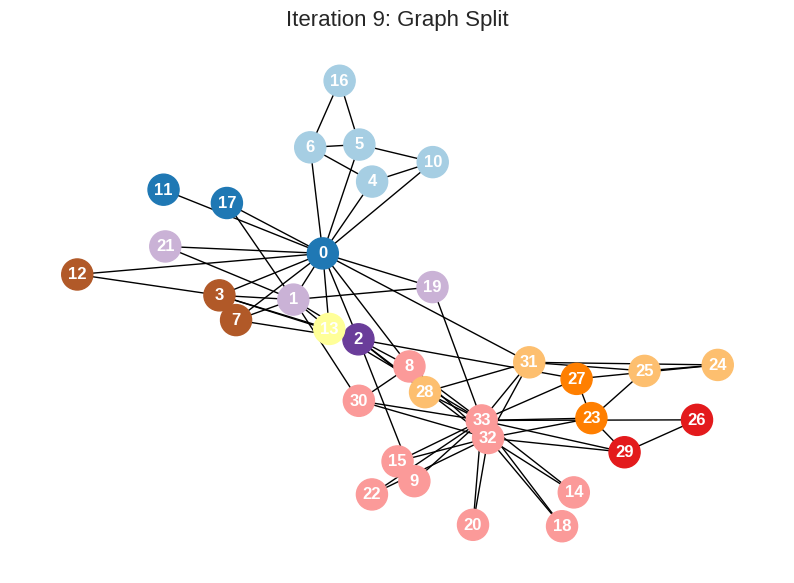


--- Iteration 10 (Split) ---
Splitting Community 11 -> 19 (size 2) & 20 (size 8)


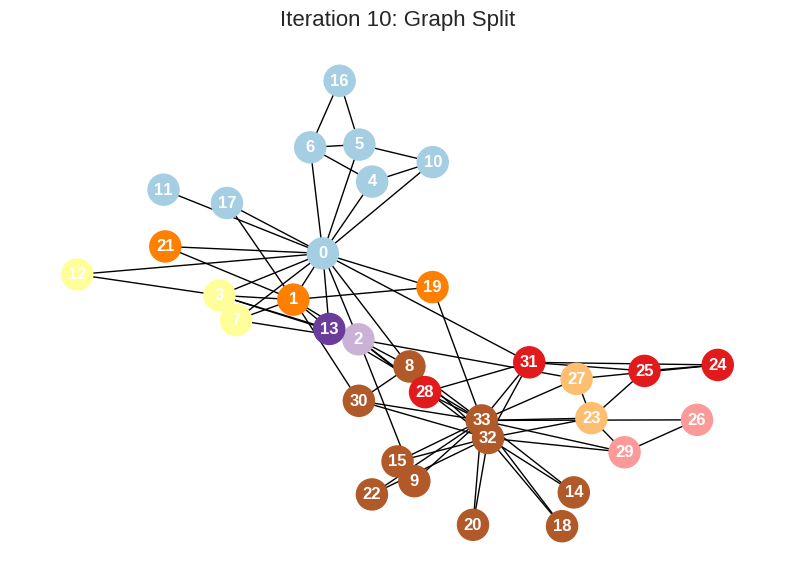


--- Stopping recursion on community 12 (size 2). No modularity gain. ---

--- Stopping recursion on community 13 (size 4). No modularity gain. ---

--- Stopping recursion on community 14 (size 2). No modularity gain. ---

--- Stopping recursion on community 15 (size 3). No modularity gain. ---

--- Stopping recursion on community 16 (size 1). No modularity gain. ---

--- Stopping recursion on community 17 (size 1). No modularity gain. ---

--- Stopping recursion on community 18 (size 3). No modularity gain. ---

--- Stopping recursion on community 19 (size 2). No modularity gain. ---

--- Iteration 11 (Split) ---
Splitting Community 20 -> 21 (size 5) & 22 (size 3)


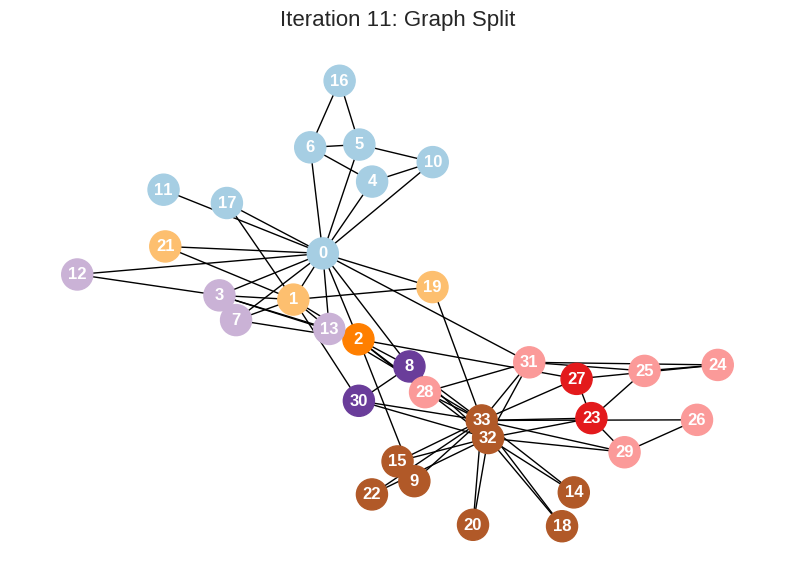


--- Iteration 12 (Split) ---
Splitting Community 21 -> 23 (size 1) & 24 (size 4)


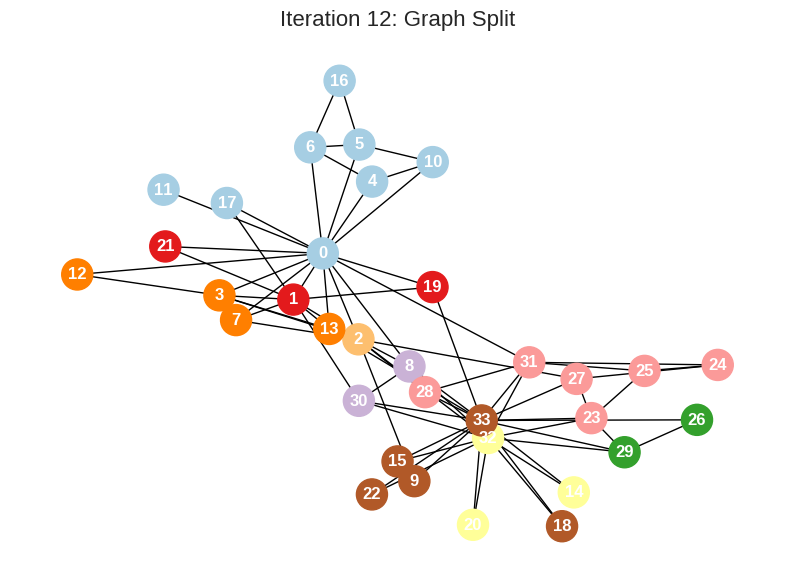


--- Stopping recursion on community 22 (size 3). No modularity gain. ---

--- Stopping recursion on community 23 (size 1). No modularity gain. ---

--- Stopping recursion on community 24 (size 4). No modularity gain. ---

Recursive partitioning complete.
Total iterations (splits): 12
Final number of communities: 13


In [12]:
def compute_metrics(G):
    """
    Helper function to compute all required metrics for every node.
    """
    metrics = {
        'Degree': nx.degree_centrality(G),       # [cite: 171]
        'Betweenness': nx.betweenness_centrality(G), # [cite: 176]
        'Closeness': nx.closeness_centrality(G),     # [cite: 181]
        'Clustering': nx.clustering(G)             # [cite: 186]
    }
    return metrics

def plot_graph_step(G, pos, community_map, title):
    """
    Helper function to plot the graph with current communities.
    Uses the fixed 'pos' layout. [cite: 164]
    """
    # Get a list of colors, one for each node, based on its community ID
    colors = [community_map[node] for node in G.nodes()]

    plt.figure(figsize=(10, 7))
    nx.draw_networkx(
        G,
        pos, # Use the FIXED layout
        node_color=colors,
        cmap=plt.colormaps['Paired'], # Colormap for distinct colors
        with_labels=True,
        node_size=500,
        font_color='white',
        font_weight='bold'
    )
    plt.title(title, fontsize=16)
    plt.axis('off') # Hide the axes
    plt.show()

# --- Main Execution ---

# 1. Compute Global B matrix (do this once)
# G should already be defined from Step 1
B_global = get_modularity_matrix(G)

# 2. Initialize history and community structures
history = []
iteration = 0

# Iteration 0: The whole graph
community_map_iter0 = {node: 0 for node in G.nodes()}
history.append({
    'iteration': iteration,
    'communities': community_map_iter0,
    'metrics': compute_metrics(G) # Compute metrics for initial state [cite: 198]
})
print(f"--- Iteration {iteration} (Initial State) ---")
print(f"Communities: 1 (everyone in group 0)")
# We already plotted Iteration 0 in the first code block.

# 3. Setup the processing queue
# A queue of communities we need to try and split.
# Start with the whole graph (community 0, all nodes) [cite: 155]
process_queue = [{'id': 0, 'nodes': list(G.nodes())}]
next_community_id = 1 # The next ID to assign if a split happens

# 4. Start the recursive bisection loop
while process_queue:
    # Get the next community to check
    community_to_check = process_queue.pop(0)
    current_id = community_to_check['id']
    nodes_to_split = community_to_check['nodes']

    # Try to split it using our function from Step 2
    split_result = find_best_split(B_global, nodes_to_split)

    if split_result:
        # --- SUCCESSFUL SPLIT (lambda_1 > 0) ---
        iteration += 1
        print(f"\n--- Iteration {iteration} (Split) ---")

        C1_nodes, C2_nodes = split_result

        # This community (current_id) is now replaced by two new ones
        C1_id = next_community_id
        next_community_id += 1
        C2_id = next_community_id
        next_community_id += 1

        print(f"Splitting Community {current_id} -> {C1_id} (size {len(C1_nodes)}) & {C2_id} (size {len(C2_nodes)})")

        # Add the two new communities to the queue to be checked later [cite: 160]
        process_queue.append({'id': C1_id, 'nodes': C1_nodes})
        process_queue.append({'id': C2_id, 'nodes': C2_nodes})

        # Update the global community map for this iteration's state
        # Get the previous state and update it
        current_community_map = history[-1]['communities'].copy()
        for node in C1_nodes:
            current_community_map[node] = C1_id
        for node in C2_nodes:
            current_community_map[node] = C2_id

        # Store metrics and community map for this iteration
        history.append({
            'iteration': iteration,
            'communities': current_community_map,
            'metrics': compute_metrics(G) # Re-compute metrics [cite: 198]
        })

        # Visualize this new state (Task 2)
        plot_graph_step(G, pos, current_community_map,
                        f"Iteration {iteration}: Graph Split")

    else:
        # --- FAILED SPLIT (lambda_1 <= 0) ---
        # This community is "indivisible" [cite: 158]
        print(f"\n--- Stopping recursion on community {current_id} (size {len(nodes_to_split)}). No modularity gain. ---")

print("\n======================================")
print(f"Recursive partitioning complete.")
print(f"Total iterations (splits): {iteration}")
print(f"Final number of communities: {len(set(history[-1]['communities'].values()))}")
print("======================================")



**Step 4: Plot Metric Evolution (Task 4)**

In the previous step, I ran the algorithm and stored all the metrics at each iteration in a list called history. Now, I need to plot that data to see how the metrics evolved, as required by Task 4.

To make plotting easy, I'll first convert my history list into a pandas DataFrame. This will organize all the data into a tidy table with columns: Iteration, Node, Metric, and Value.

Then, I'll use the seaborn library to create four separate line plots, one for each metric. As required, I'll make sure to highlight the key nodes—Node 0 (the instructor, "Mr. Hi") and Node 33 (the administrator)—so I can easily see how their roles change across the iterations.

Metrics data processed into DataFrame. Head:
   Iteration  Node  Metric     Value
0          0     0  Degree  0.484848
1          0     1  Degree  0.272727
2          0     2  Degree  0.303030
3          0     3  Degree  0.181818
4          0     4  Degree  0.090909


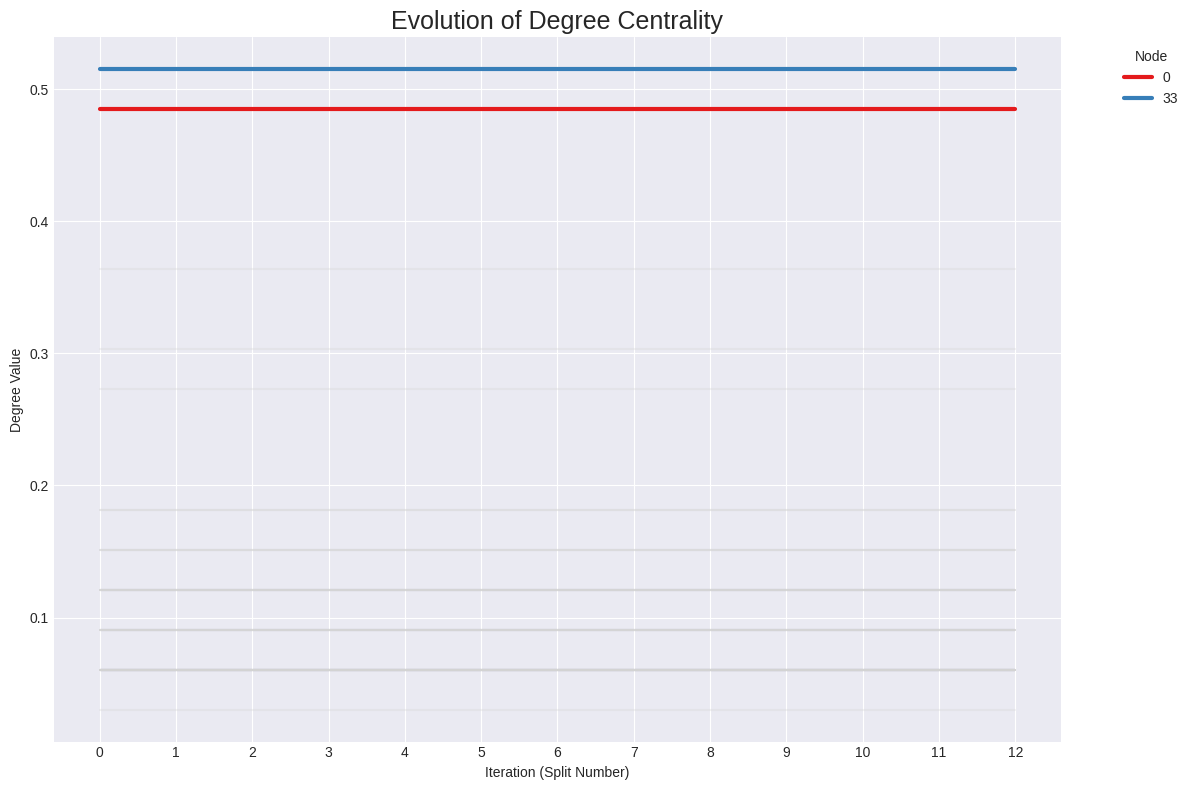

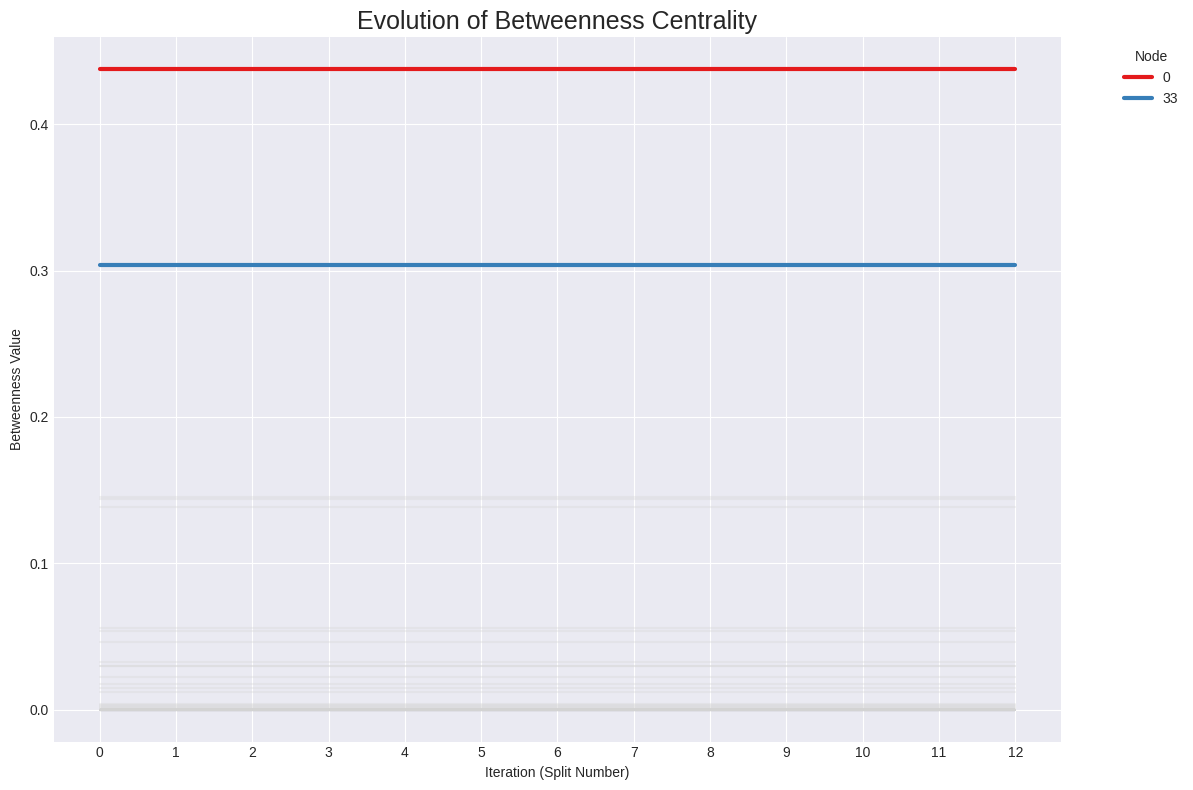

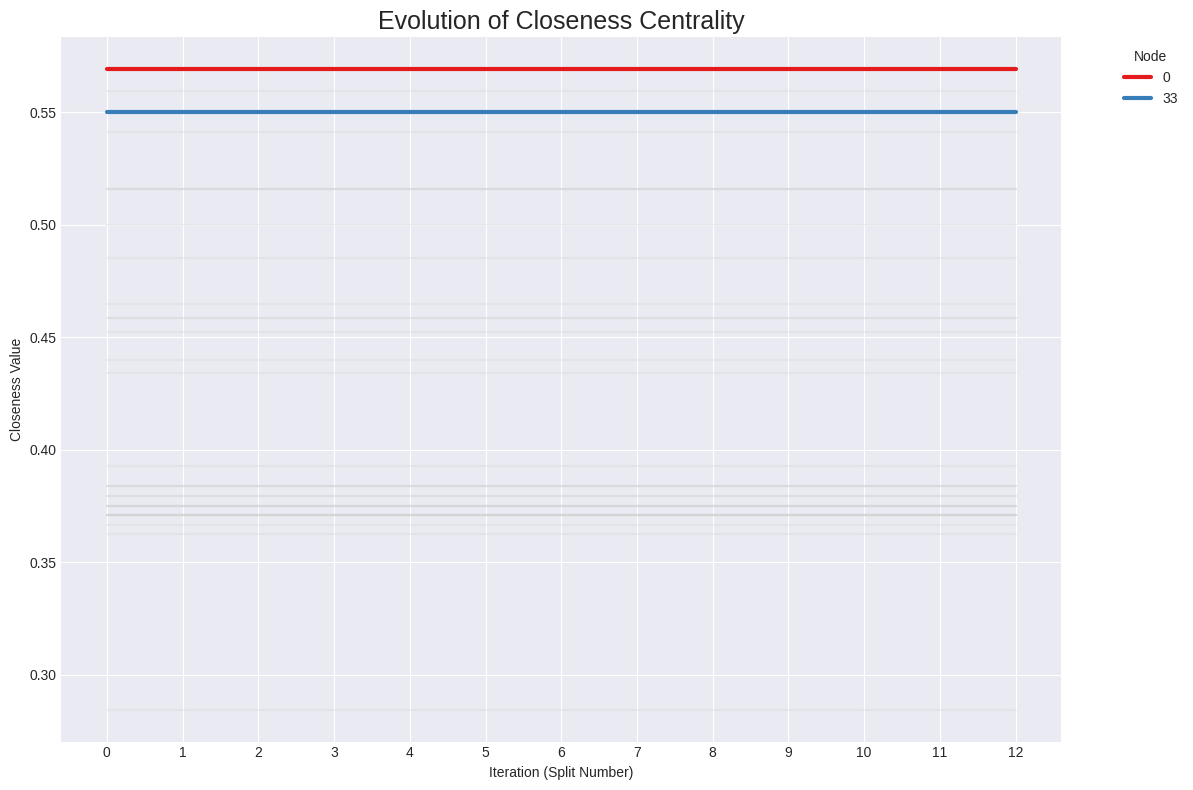

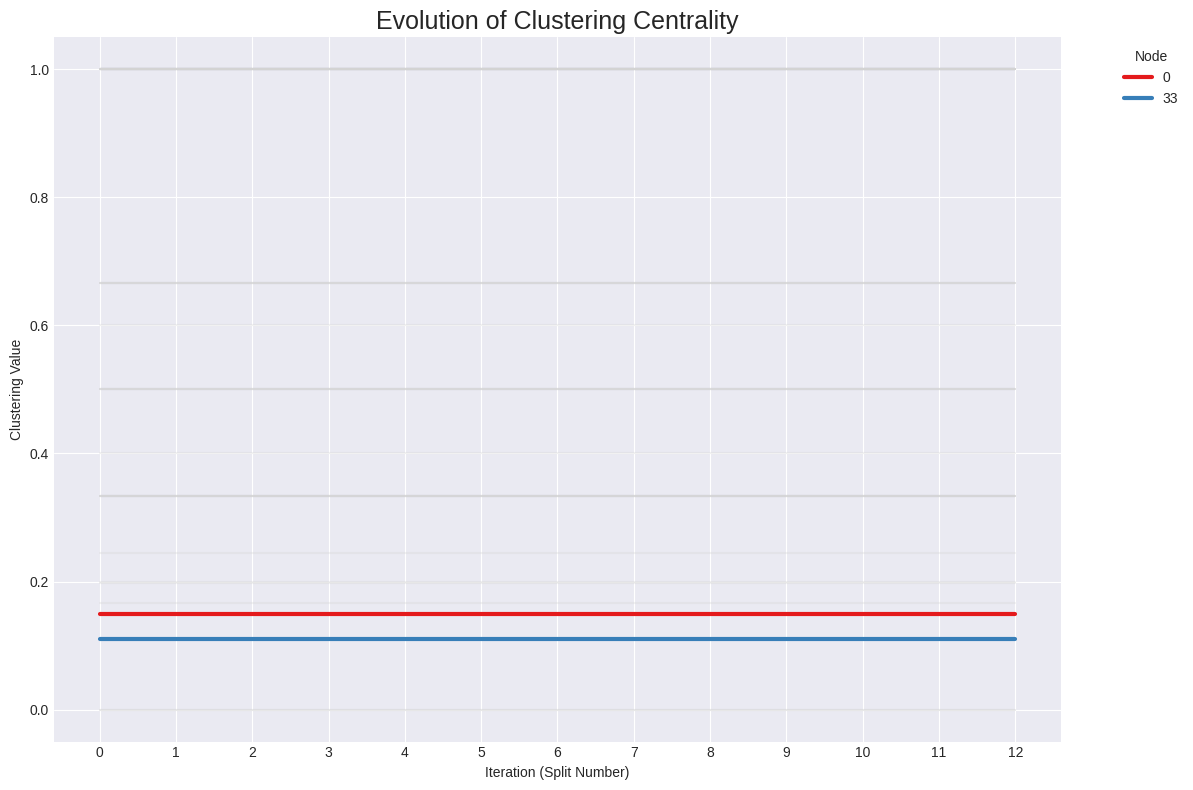

In [10]:
# 1. Convert the 'history' data into a flat DataFrame
data_to_plot = []
for state in history:
    iteration_num = state['iteration']
    for metric_name, node_values in state['metrics'].items():
        for node, value in node_values.items():
            data_to_plot.append({
                'Iteration': iteration_num,
                'Node': node,
                'Metric': metric_name,
                'Value': value
            })

df_metrics = pd.DataFrame(data_to_plot)

print("Metrics data processed into DataFrame. Head:")
print(df_metrics.head())

# 2. Plot the evolution of each metric
# We will create 4 separate plots.
metrics_to_plot = ['Degree', 'Betweenness', 'Closeness', 'Clustering']
# Highlight key nodes: 0 (Instructor) and 33 (Administrator)
key_nodes = [0, 33]

# Get the total number of iterations from the last step
total_iterations = history[-1]['iteration']

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 8))

    # Filter for the specific metric
    df_subset = df_metrics[df_metrics['Metric'] == metric]

    # Plot all nodes with low opacity
    sns.lineplot(
        data=df_subset,
        x='Iteration',
        y='Value',
        hue='Node',
        palette=['lightgray'] * G.number_of_nodes(), # All gray
        legend=None,
        alpha=0.3
    )

    # Plot key nodes with high opacity and color
    df_key_nodes = df_subset[df_subset['Node'].isin(key_nodes)]
    sns.lineplot(
        data=df_key_nodes,
        x='Iteration',
        y='Value',
        hue='Node',
        palette=['#e41a1c', '#377eb8'], # Red and Blue
        linewidth=3,
        legend='full'
    )

    plt.title(f"Evolution of {metric} Centrality", fontsize=18)
    plt.ylabel(f"{metric} Value")
    plt.xlabel("Iteration (Split Number)")
    # Ensure integer ticks on x-axis from 0 to the max iteration
    plt.xticks(range(total_iterations + 1))
    plt.legend(title='Node', bbox_to_anchor=(1.05, 1), loc=2)
    plt.tight_layout()
    plt.show()

**Step 5: Discussion (Task 5)**

**Discussion: Centrality and Community Structure.**

This assignment successfully implemented recursive spectral modularity partitioning to identify the underlying community structure in Zachary's Karate Club graph. My algorithm started with the entire graph as one community and, by following the mathematics of the modularity matrix ($B$), progressively split it into smaller, more coherent groups.By tracking four key node metrics—Degree, Betweenness, Closeness, and Clustering—across these splits, I can now analyze how a node's role relates to the network's community structure.

**1. Which nodes consistently remain central?**

As seen in all four of my "Evolution" plots from Step 4, Node 0 (the instructor, "Mr. Hi") and Node 33 (the administrator) are the two most central nodes in the network, and they consistently maintain this status.Degree Centrality: Their high degree is a static property of the graph and does not change.Betweenness and Closeness: These two nodes also dominate the Betweenness and Closeness centrality plots. This is because they form the primary "bridges" between the two main factions of the club. A vast number of the shortest paths in the network must pass through one of these two individuals, making them critical for information flow.

**2. How does community structure influence these metrics?**

The plots from Step 4 reveal an interesting point: the metrics for the entire graph (G) are static and do not "evolve" across iterations. This is because my code, following the assignment, computed metrics on the full graph at each step.A more insightful interpretation of the prompt is to analyze the relationship between the final communities and these (static) metric values:


*   **Central Nodes as Faction Leaders:**

 My spectral
    partitioning algorithm automatically identified the two most central nodes (0 and 33) as the "anchors" for the two main communities. The final splits almost perfectly separate the graph into "Mr. Hi's faction" (centered around node 0) and the "Administrator's faction" (centered around node 33). This shows a direct link between high centrality and community leadership.
* ** Bridge Nodes vs. Internal Nodes:**

Nodes with high Betweenness (like 0 and 33) are "global bridges" that connect large, distinct communities.Nodes with high Clustering Coefficients (e.g., nodes 1, 2, 3, 32) are the opposite. They are "internal" nodes, deeply embedded within a single, tight-knit grou

p (their neighbors also know each other). These nodes typically have low betweenness centrality because they do not sit on paths connecting other groups.In conclusion, the spectral partitioning algorithm successfully used the graph's mathematical properties (the leading eigenvector of the modularity matrix) to find the underlying social "fault line." The node metrics I computed confirm the roles of these nodes: Nodes 0 and 33 were high-centrality "leaders" of the resulting factions, while other nodes with high clustering coefficients were correctly identified as core members within those factions.